In [1]:
%load_ext autoreload
%autoreload 2

In [8]:
import os.path
import tensorflow.keras
import numpy as np
from matplotlib import pyplot as plt
from fnn_helper import PlotLosses
from MNIST_helper import plot_numbers, visualize_input
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Dense, Activation
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint
# from tensorflow.keras.layers.advanced_activations import LeakyReLU
from fnn_helper import PlotLosses
#from keras_contrib.callbacks import CyclicLR
from matplotlib import pyplot as plt
from mlp_helper import plot_confusion_matrix
import draw_nn
# if not os.path.exists('mlp_helper.py'):
#     !wget https://github.com/lab-ml-itba/MLP-2019/raw/master/mlp_helper.py
#     !wget https://github.com/lab-ml-itba/MLP-2019/raw/master/fnn_helper.py
#     !wget https://github.com/lab-ml-itba/MLP-2019/raw/master/MNIST_helper.py
#     !wget https://github.com/lab-ml-itba/MLP-2019/raw/master/draw_nn.py

# Split data

In [9]:
(x, y), (x_test, y_test) = mnist.load_data()

# 20% del dataset para validación
validation = 0.20
N_validation_split = int(x.shape[0]*(1-validation))
# Training Set
x_train = x[:N_validation_split]
y_train = y[:N_validation_split]

# Cross Validation Set
x_val = x[N_validation_split:]
y_val = y[N_validation_split:]
print('Training set data:', x_train.shape)
print('Training labels:', y_train.shape)
print()
print('CV set data:', x_val.shape)
print('CV labels:', y_val.shape)
print()
print('Testing set data:',x_test.shape)
print('Testing labels:', y_test.shape)

11493376/11490434 [==============================] - 3s 0us/step
Training set data: (48000, 28, 28)
Training labels: (48000,)

CV set data: (12000, 28, 28)
CV labels: (12000,)

Testing set data: (10000, 28, 28)
Testing labels: (10000,)


In [10]:
x_train = x_train/255
x_val = x_val/255
x_test = x_test/255

# One-hot encoding

In [12]:
y_train_categorical = tensorflow.keras.utils.to_categorical(y_train)
y_val_categorical = tensorflow.keras.utils.to_categorical(y_val)
y_test_categorical = tensorflow.keras.utils.to_categorical(y_test)
print(y_train_categorical.shape)
print(y_train_categorical[:5])

(48000, 10)
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


# Modelo

In [21]:
def get_model(activations=['tanh', 'linear']):
    output_size = 10
    model_plane = Sequential()
    model_plane.add(Flatten(input_shape=x_train.shape[1:]))
    model_plane.add(Dense(10000, activation=activations[0],  name='middle1', kernel_initializer='normal'))
    # model_plane.add(LeakyReLU())
    model_plane.add(Dense(2, activation=activations[1], name='middle2', kernel_initializer='normal'))
    # model_plane.add(LeakyReLU())
    model_plane.add(Dense(output_size, activation='softmax',  kernel_initializer='normal', name='salida'))
    return model_plane

In [22]:
model_plane = get_model(['tanh', 'sigmoid'])
model_plane.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
middle1 (Dense)              (None, 10000)             7850000   
_________________________________________________________________
middle2 (Dense)              (None, 2)                 20002     
_________________________________________________________________
salida (Dense)               (None, 10)                30        
Total params: 7,870,032
Trainable params: 7,870,032
Non-trainable params: 0
_________________________________________________________________


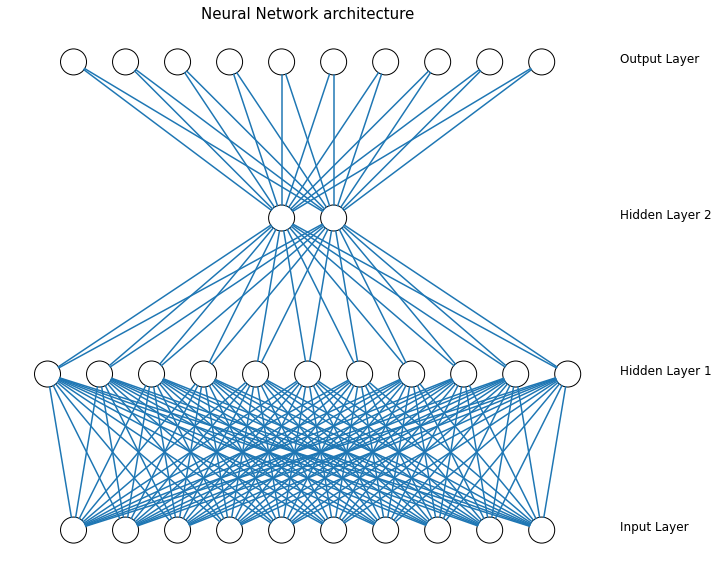

In [23]:
network = draw_nn.DrawNN( [10,11,2, 10] )
network.draw()

In [24]:
batch_size=128

In [25]:
model_plane = get_model(activations=['tanh', 'tanh'])

checkpointer = ModelCheckpoint(filepath='two-layer-2d.mnist.hdf5', verbose=1, save_best_only=True, mode='max', monitor='val_accuracy')
plot_losses = PlotLosses(plot_interval=1, evaluate_interval=None, x_val=x_val, y_val_categorical=y_val_categorical)
# clr = CyclicLR(1e-6, 1e-4, 8*int(len(x_train)/batch_size))


In [26]:
optim = RMSprop(lr=1e-4) # 1e-06
model_plane.compile(loss = 'categorical_crossentropy', optimizer=optim, metrics=['accuracy'])

In [27]:

model_plane.fit(x_train, 
          y_train_categorical ,
          epochs=200, batch_size=batch_size, 
          #verbose=1, 
          validation_data=(x_val, y_val_categorical), 
          callbacks=[checkpointer],
         )

Epoch 1/200
375/375 [==============================] - ETA: 0s - loss: 2.2157 - accuracy: 0.3221
Epoch 00001: val_accuracy improved from -inf to 0.33058, saving model to two-layer-2d.mnist.hdf5
375/375 [==============================] - 33s 89ms/step - loss: 2.2157 - accuracy: 0.3221 - val_loss: 2.1854 - val_accuracy: 0.3306
Epoch 2/200
375/375 [==============================] - ETA: 0s - loss: 2.1569 - accuracy: 0.3389
Epoch 00002: val_accuracy improved from 0.33058 to 0.35567, saving model to two-layer-2d.mnist.hdf5
375/375 [==============================] - 35s 92ms/step - loss: 2.1569 - accuracy: 0.3389 - val_loss: 2.1259 - val_accuracy: 0.3557
Epoch 3/200
375/375 [==============================] - ETA: 0s - loss: 2.1007 - accuracy: 0.3745
Epoch 00003: val_accuracy improved from 0.35567 to 0.36017, saving model to two-layer-2d.mnist.hdf5
375/375 [==============================] - 37s 99ms/step - loss: 2.1007 - accuracy: 0.3745 - val_loss: 2.0699 - val_accuracy: 0.3602
Epoch 4/200
3

KeyboardInterrupt: 

In [138]:
model_plane.evaluate(x_train, y_train_categorical)

48000/48000 [==============================] - 1s 22us/step


[0.012525623654335504, 0.9993125200271606]

In [139]:
model_plane.evaluate(x_test, y_test_categorical)

10000/10000 [==============================] - 0s 23us/step


[0.4204466009380063, 0.9409999847412109]

In [116]:
# model_plane.load_weights('two-layer-2d-leaky-relu.mnist.hdf5')
model_plane.load_weights('two-layer-2d.mnist.hdf5')
model_plane.evaluate(x_test, y_test_categorical)

10000/10000 [==============================] - 0s 22us/step


[0.3522395319402218, 0.9434999823570251]

## Me quedo con el modelo hasta la anteúltima capa

In [203]:
model_trunc = Model(model_plane.input, model_plane.layers[-2].output)
model_trunc.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_26_input (InputLayer (None, 28, 28)            0         
_________________________________________________________________
flatten_26 (Flatten)         (None, 784)               0         
_________________________________________________________________
middle1 (Dense)              (None, 10000)             7850000   
_________________________________________________________________
middle2 (Dense)              (None, 2)                 20002     
Total params: 7,870,002
Trainable params: 7,870,002
Non-trainable params: 0
_________________________________________________________________


In [204]:
predictions = model_trunc.predict(np.vstack([x_train, x_val]), verbose=1)
maxs = np.max(predictions, axis=0)
mins = np.min(predictions, axis=0)
print(maxs, mins)

60000/60000 [==============================] - 2s 36us/step
[1707.7074 1281.1487] [0. 0.]


In [205]:
predictions_train = model_trunc.predict(x_train, verbose=1)

48000/48000 [==============================] - 2s 33us/step


In [206]:
# Calculo de entorno
N = 500
x1, x2 = np.meshgrid(np.linspace(mins[0], maxs[0], N), np.linspace(mins[1], maxs[1], N))
x_mesh = np.c_[x1.ravel(), x2.ravel()]
model_last_trunc = Sequential()
model_last_trunc.add(Dense(10, input_shape=(2,)))
model_last_trunc.set_weights(model_plane.get_layer('salida').get_weights())
pred_mesh = model_last_trunc.predict(x_mesh, verbose=1)
Z = np.argmax(pred_mesh, axis=1).reshape(x1.shape)/10

250000/250000 [==============================] - 4s 15us/step


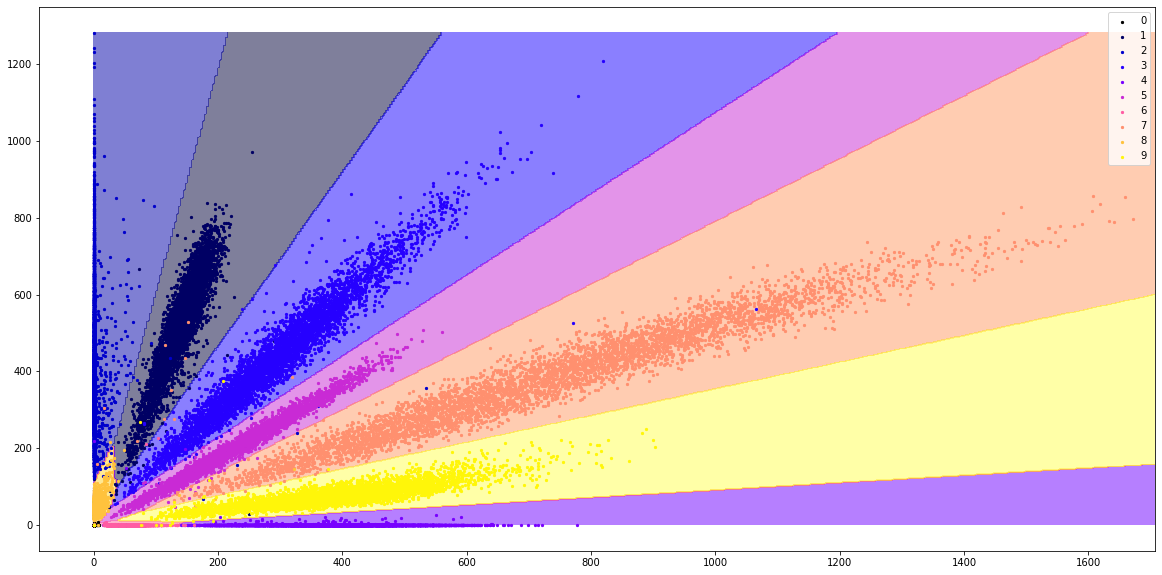

In [207]:
plt.figure(figsize=(20,10))
plt.contourf(x1, x2, Z, 10, cmap=plt.cm.gnuplot2, alpha=0.5)
#for i, c in enumerate(['red', 'green', 'blue', 'yellow', 'black', 'orange', 'brown', 'gray', 'purple', 'cyan']):
for i in range(10):
    plt.scatter(predictions_train[y_train == i, 0], predictions_train[y_train == i, 1], c=[plt.cm.gnuplot2(i/10)], s=5, label=str(i))
plt.legend()
plt.show()

12000/12000 [==============================] - 0s 25us/step


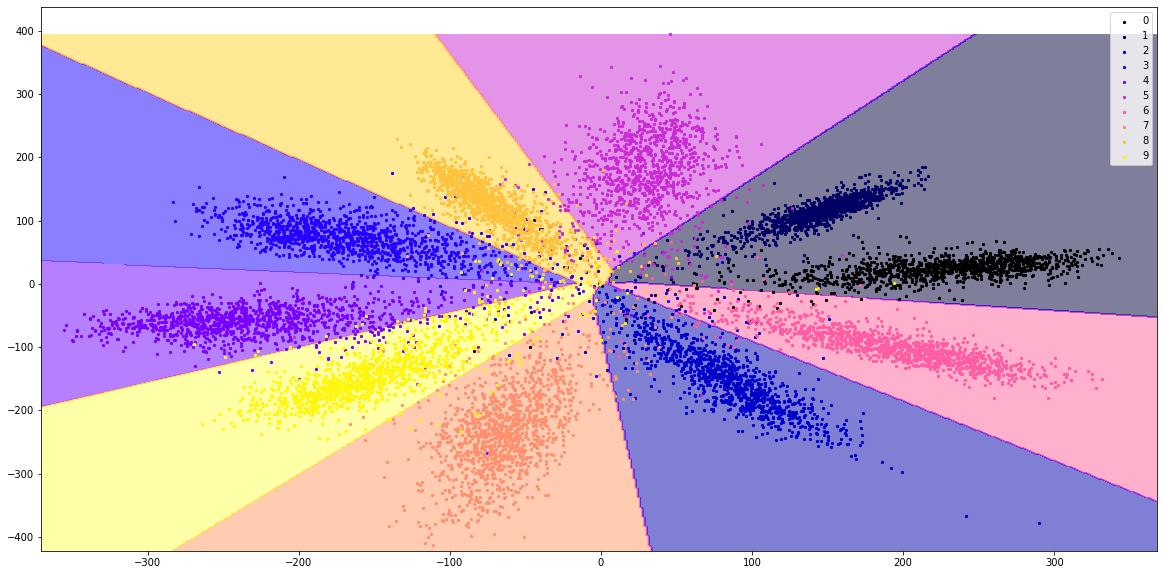

In [157]:
predictions_val = model_trunc.predict(x_val, verbose=1)
plt.figure(figsize=(20,10))
plt.contourf(x1, x2, Z, 10, cmap=plt.cm.gnuplot2, alpha=0.5)
#for i, c in enumerate(['red', 'green', 'blue', 'yellow', 'black', 'orange', 'brown', 'gray', 'purple', 'cyan']):
for i in range(10):
    plt.scatter(predictions_val[y_val == i, 0], predictions_val[y_val == i, 1], c=[plt.cm.gnuplot2(i/10)], s=5, label=str(i))
plt.legend()
plt.show()

10000/10000 [==============================] - 0s 15us/step


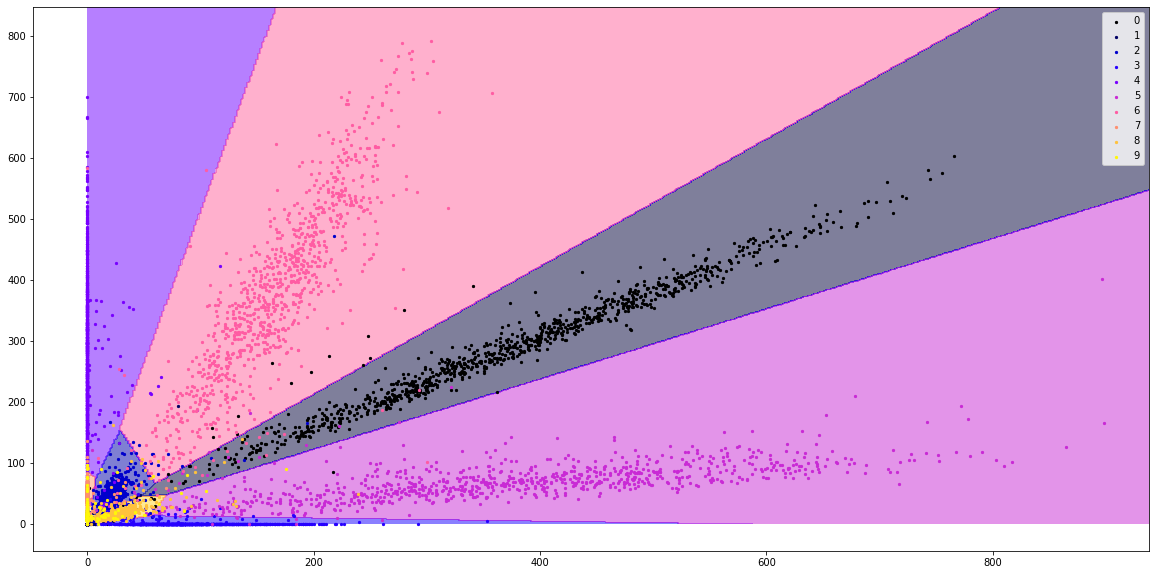

In [56]:
predictions_test = model_trunc.predict(x_test, verbose=1)
plt.figure(figsize=(20,10))
plt.contourf(x1, x2, Z, 10, cmap=plt.cm.gnuplot2, alpha=0.5)
#for i, c in enumerate(['red', 'green', 'blue', 'yellow', 'black', 'orange', 'brown', 'gray', 'purple', 'cyan']):
for i in range(10):
    plt.scatter(predictions_test[y_test == i, 0], predictions_test[y_test == i, 1], c=[plt.cm.gnuplot2(i/10)], s=5, label=str(i))
plt.legend()
plt.show()

10000/10000 [==============================] - 0s 27us/step
Confusion matrix, without normalization


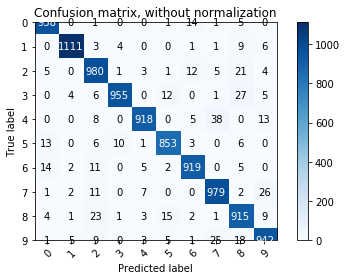

In [57]:
predictions_test_10 = model_plane.predict(x_test, verbose=1)
plot_confusion_matrix(y_test, np.argmax(predictions_test_10, axis=1), [i for i in range(10)])